In [1]:
%matplotlib inline
import os
import json
import argparse

import numpy as np

from scipy.integrate import quad

from astropy.io import fits
from astropy.time import Time

from desispec.interpolation import resample_flux

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', family='serif', size=14)

In [2]:
galaxy_file = "../galaxy_sim_catalog/spectra/galaxies/spectra-20190401-expid004-00048.fits"

sn_template_basedir = "../galaxy_sim_catalog/sn_templates"
sn_template = "%s/SN2011fe.json" % sn_template_basedir

In [3]:
# Make sure environments are setup properly
def check_env():
    for env in ('DESIMODEL', 'DESI_ROOT', 'DESI_SPECTRO_SIM', 'DESI_SPECTRO_DATA',
                                'DESI_SPECTRO_REDUX', 'SPECPROD', 'PIXPROD'):
        if env in os.environ:
            print('{} environment set to {}'.format(env, os.getenv(env)))
        else:
            print('Required environment variable {} not set!'.format(env))

check_env()

DESIMODEL environment set to /Users/ryanrubenzahl/Documents/DESI/code//desimodel
DESI_ROOT environment set to /Users/ryanrubenzahl/Documents/DESI
DESI_SPECTRO_SIM environment set to /Users/ryanrubenzahl/Documents/DESI/spectro/sim
DESI_SPECTRO_DATA environment set to /Users/ryanrubenzahl/Documents/DESI/spectro/data
DESI_SPECTRO_REDUX environment set to /Users/ryanrubenzahl/Documents/DESI/spectro/redux
SPECPROD environment set to dailytest
PIXPROD environment set to dailytest


In [4]:
# Read in supernova template
with open(sn_template, 'r') as f:
    sn_name = sn_template.split('.')[-2].split('/')[-1]
    sn_data = json.load(f)
    
sn_type = sn_data[sn_name]['claimedtype'][0]['value']
print sn_name, ": type", sn_type

SN2011fe : type Ia


In [5]:
# Get lightcurve peak date
sn_peak_iso = sn_data[sn_name]['maxvisualdate'][0]['value']
sn_peak_mjd = Time(sn_peak_iso.replace('/', '-')).mjd
sn_peak_mjd

55814.0

In [6]:
# Grab a random epoch with sufficient observation
sn_waves  = []
sn_fluxes = []
sn_epochs = []

for sn_spectra in sn_data[sn_name]['spectra']:
    sn_flux_unit = sn_spectra['u_fluxes']
    sn_wave_unit = sn_spectra['u_wavelengths']
    sn_time_unit = sn_spectra['u_time']
    
    if sn_flux_unit == 'Uncalibrated':
        continue
        
    sn_time = sn_spectra['time']
    sn_spectra_data = np.array(sn_spectra['data'])
    sn_wave = np.array(sn_spectra_data[:,0], dtype=np.float32)
    sn_flux = np.array(sn_spectra_data[:,1], dtype=np.float32)
    
    if np.max(sn_wave) < 9000 or np.min(sn_wave) > 3000:
        continue

    sn_epoch = float(sn_time) - sn_peak_mjd
    sn_epochs.append(np.array(sn_epoch, dtype=np.float32))
    sn_waves.append(np.array(sn_wave, dtype=np.float32))
    sn_fluxes.append(np.array(sn_flux, dtype=np.float32))
    
rand_epoch = np.random.randint(len(sn_epochs))
rand_epoch = 4 # PEAK FOR TESTING
sn_wave  = sn_waves[rand_epoch]
sn_flux  = sn_fluxes[rand_epoch]
sn_epoch = sn_epochs[rand_epoch]

# Get the peak overall flux of the supernova
sn_fluxes = np.array(sn_fluxes)
sn_epochs = np.array(sn_epochs)
sn_peak_spectra = np.concatenate(sn_fluxes[sn_epochs == np.min(np.abs(sn_epochs))])
sn_peak_flux = np.mean(sn_peak_spectra)

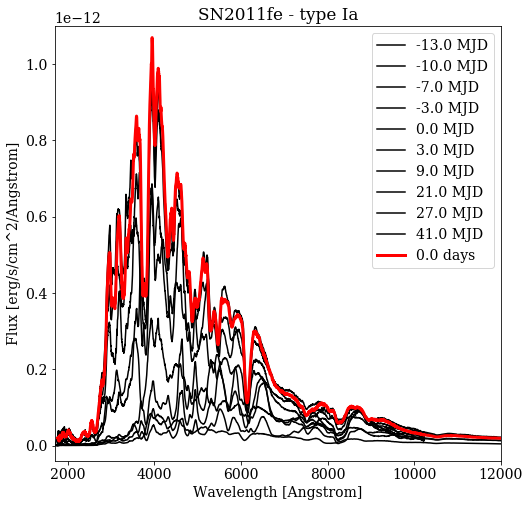

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8,8))


i = 0
for epoch, wave, flux in zip(sn_epochs, sn_waves, sn_fluxes):
    i += 1
#     if i > 20:
#         break
           
    ax.plot(wave, flux, color='k', label='%s %s' % (epoch, sn_time_unit))

    
ax.plot(sn_wave, sn_flux, color='r', lw=3, label='%s days' % (sn_epoch))
ax.set(xlabel='Wavelength [%s]' % sn_wave_unit,
           ylabel='Flux [%s]' % sn_flux_unit,
           title='%s - type %s' % (sn_name, sn_type),
           xlim=[1700, 12000],
           ylim=[-.4e-13, 11e-13])
ax.legend(loc='upper right')
# plt.savefig('plots/SN-template.png', format='png', 
#             dpi=300, bbox_inches='tight')

In [8]:
# Read in simulated galaxy spectra
gal_hdul = fits.open(galaxy_file)

gal_Z = gal_hdul[0].header['REDSHIFT']
gal_flux_unit = float(gal_hdul[2].header['BUNIT'].split(' ')[0])
gal_wave = gal_hdul[1].data
gal_flux = gal_hdul[2].data * gal_flux_unit

gal_hdul.close()

In [9]:
# Redshift supernova template to the galaxy redshift
sn_wave *= (gal_Z + 1)

In [10]:
# Get distance to galaxy
H0 = 73.45 # Hubble Constant [km/s/Mpc]
OmegaM = 0.286 # Energy density of matter
OmegaL = 0.714 # Energy density of dark energy
c = 299792.458 # Speed of light [km/s]
DH = c / H0 # Hubble distance

def inverseE(z):
    return 1./np.sqrt(OmegaM*(1+z)**3 + OmegaL)

def comoving_distance(z):
    return DH * quad(inverseE, 0, z)[0]

def luminosity_distance(z):
    return (1+z)*comoving_distance(z)

gal_dist = luminosity_distance(gal_Z) # Mpc
print gal_dist, "Mpc"

352.327442501 Mpc


In [11]:
# Get distance to supernova
m0V = float(sn_data[sn_name]['maxvisualappmag'][0]['value'])
M0V = float(sn_data[sn_name]['maxvisualabsmag'][0]['value'])
m = float(sn_data[sn_name]['maxappmag'][0]['value'])
M = float(sn_data[sn_name]['maxabsmag'][0]['value'])

print "m0V:", m0V
print "M0V:", M0V
print "m:", m
print "M:", M
print

# Luminosity distance from file
sn_dist = float(sn_data[sn_name]['lumdist'][0]['value'])
print "luminosity distance:", sn_dist, "Mpc"

# Comoving distance from file
print "comoving distance:", sn_data[sn_name]['comovingdist'][0]['value'], "Mpc"

# Using magnitudes from file and distance modulus
print "from app/abs visual magnitude:", 10*10**((m0V - M0V)/5.) / 1e6, "Mpc"
print "from app/abs magnitude:", 10*10**((m - M)/5.) / 1e6, "Mpc"

M0V = -19.14
print "from app mag + Riess abs mag:", 10*10**((m0V - M0V)/5.) / 1e6, "Mpc"
print "Wikipedia distance (M101):", 21/3.26, "Mpc"

m0V: 9.893
M0V: -17.86
m: 9.48
M: -18.28

luminosity distance: 3.56 Mpc
comoving distance: 5.92 Mpc
from app/abs visual magnitude: 3.55303920815 Mpc
from app/abs magnitude: 3.56451133426 Mpc
from app mag + Riess abs mag: 6.40619272627 Mpc
Wikipedia distance (M101): 6.44171779141 Mpc


In [12]:
# Apparent magnitude of SN at host galaxy
sn_appmag = M0V + 5*np.log10(gal_dist*1e6 / 10)
print "%.3f at %.2f Mpc" % (sn_appmag, gal_dist)

18.595 at 352.33 Mpc


In [13]:
# Add supernova
gal_flux_max = np.max(gal_flux)

# Resample SN template to match galaxy spectra wavelength grid
sn_flux_ivar = None # TODO? add uncertainties
if sn_flux_ivar==None:
    sn_flux_resample = resample_flux(gal_wave, sn_wave, sn_flux, extrapolate=True)
    sn_flux_resample_ivar = None
else:
    sn_flux_resample, sn_flux_resample_ivar  = resample_flux(gal_wave, sn_wave, sn_flux, ivar=sn_flux_ivar)

# Scale supernova to galaxy
# sn_scaled_flux = sn_flux_resample * (sn_dist / gal_dist)**2
norm = np.median(gal_flux) / np.median(sn_flux_resample)

sn_scaled_flux = norm * sn_flux_resample

sn_fluxratio = np.max(sn_scaled_flux) / gal_flux_max

# Add together
sn_gal_flux = sn_scaled_flux + gal_flux


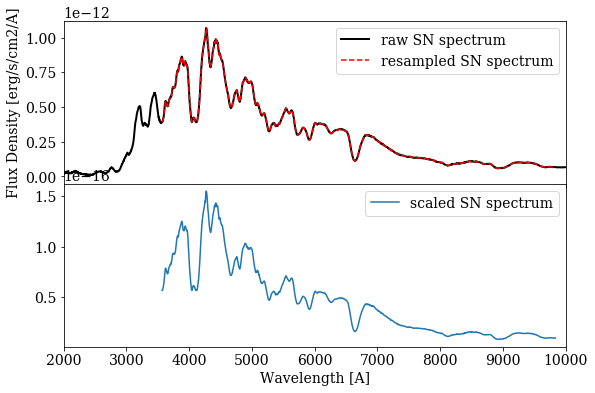

In [14]:
fig, ax = plt.subplots(2,1, figsize=(9,6), sharex=True)

objtype = gal_hdul[0].header['OBJTYPE']
ax[0].plot(sn_wave,  sn_flux, color='k', lw=2, label='raw SN spectrum')
ax[0].plot(gal_wave,  sn_flux_resample, ls='--', color='r', label='resampled SN spectrum')
ax[1].plot(gal_wave,  sn_scaled_flux, label='scaled SN spectrum')

ax[1].set_xlabel('Wavelength [A]')
ax[0].set_ylabel('Flux Density [erg/s/cm2/A]')
plt.subplots_adjust(hspace=0)

for axx in ax:
    axx.set_xlim(2000, 10000)
    axx.legend()
    

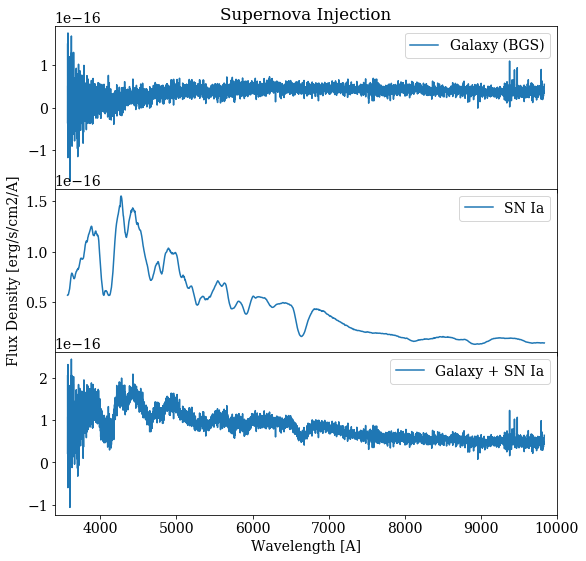

In [15]:
fig, ax = plt.subplots(3,1, figsize=(9,9), sharex=True)

objtype = gal_hdul[0].header['OBJTYPE']
ax[0].plot(gal_wave,  gal_flux, label='Galaxy (%s)'%objtype)
ax[1].plot(gal_wave,  sn_scaled_flux, label='SN Ia')
ax[2].plot(gal_wave,  sn_gal_flux, label='Galaxy + SN Ia')

ax[2].set_xlabel('Wavelength [A]')
ax[1].set_ylabel('Flux Density [erg/s/cm2/A]')
ax[0].set_title('Supernova Injection')
plt.subplots_adjust(hspace=0)

for axx in ax:
    axx.set_xlim(3400, 10000)
    axx.legend()
    
# plt.savefig('../plots/SN-injection.png', format='png', 
#             dpi=300, bbox_inches='tight')

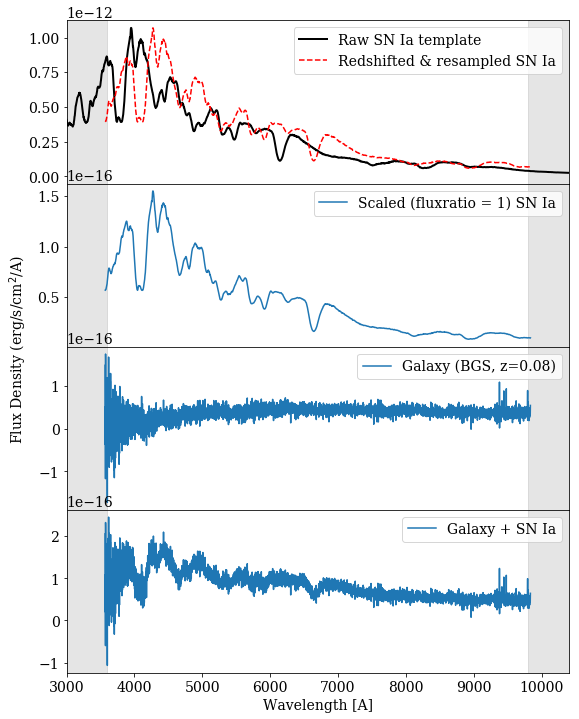

In [18]:
fig, ax = plt.subplots(4,1, figsize=(9,12), sharex=True)

objtype = gal_hdul[0].header['OBJTYPE']
ax[0].plot(sn_wave / (gal_Z + 1),  sn_flux, 
           color='k', lw=2, label='Raw SN Ia template')
ax[0].plot(gal_wave,  sn_flux_resample, 
           ls='--', color='r', label='Redshifted & resampled SN Ia')
ax[1].plot(gal_wave,  sn_scaled_flux, label='Scaled (fluxratio = 1) SN Ia')

objtype = gal_hdul[0].header['OBJTYPE']
ax[2].plot(gal_wave,  gal_flux, label='Galaxy (%s, z=%.2f)'% (objtype, gal_Z))
# ax[1].plot(gal_wave,  sn_scaled_flux, label='SN Ia')
ax[3].plot(gal_wave,  sn_gal_flux, label='Galaxy + SN Ia')

ax[3].set_xlabel('Wavelength [A]')
fig.text(0.05, 0.5, r'Flux Density (erg/s/cm$^2$/A)',
        rotation='vertical', horizontalalignment='center',
        verticalalignment='center')

# ax[0].set_title('Supernova Injection')
plt.subplots_adjust(hspace=0)

# for axx in ax:
#     axx.set_xlim(3400, 10000)
#     axx.legend()
    
for axx in ax:
    axx.set_xlim(3000, 10400)
    axx.axvspan(3000, 3600, color='k', alpha=0.1)
    axx.axvspan(9800, 10400, color='k', alpha=0.1)
    axx.legend(loc='upper right')
    
savedir = '/Users/ryanrubenzahl/Library/Ryan/College/Senior Thesis/thesis/Figures/'
# plt.savefig(savedir + 'SN-injection.png', format='png', 
#             dpi=300, bbox_inches='tight')

In [17]:
print ("we added a type %s supernova at %d days" \
        "from peak with %.4f percent of the peak galaxy " \
        "flux to a %s with redshift %.4f") % (sn_type, sn_epoch, 
                                                 sn_fluxratio*100, 
                                                 objtype, gal_Z)

we added a type Ia supernova at 0 daysfrom peak with 62.3716 percent of the peak galaxy flux to a BGS with redshift 0.0813


In [18]:
# # Write output
# outfile = galaxy_file.split('.')[0] + "-with-SN" + sn_type + ".fits"

# hdulist = fits.open(galaxy_file)

# # Add the supernova in
# hdulist[2].data = sn_gal_flux
# # Set header flag to indicate this spectra contains a supernova
# hdulist[0].header['HAS_SN'] = sn_type

# # Write to new fits file (overwrite existing if already made)
# hdulist.writeto(outfile, overwrite=False)

# hdulist.close()

In [20]:
# hdulist_new = fits.open(outfile)
# hdulist_old = fits.open(galaxy_file)

# # hdulist_old[0].header
# # hdulist_new[0].header

# plt.plot(hdulist_old[1].data, hdulist_old[2].data*1e-17, label='galaxy')
# print hdulist_old[0].header['HAS_SN']

# plt.plot(hdulist_new[1].data, hdulist_new[2].data, label='w/ SN %s'%hdulist_new[0].header['HAS_SN'])
# print hdulist_new[0].header['HAS_SN']

# plt.legend()

# hdulist_new.close()
# hdulist_old.close()

In [21]:
# Look at metadata for debugging

from astropy.table import Table

night   = '20190401' # default is current date
objtypes = ['ELG', 'LRG', 'QSO', 'BGS']
meta = {}

for expid in range(1, 5):
    objtype = objtypes[expid-1]
    
    simspecfile = '/Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/{0:s}/simspec-{1:08d}.fits'.format(night, expid)
    print('Reading simspec file {}.'.format(simspecfile))
    hdu = fits.open(simspecfile)
    # hdu.info()
    metatable = Table(hdu['TRUTH'].data)
    meta_obj = metatable[metatable['OBJTYPE']==objtype]
    meta[objtype] = meta_obj
    hdu.close()

Reading simspec file /Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/20190401/simspec-00000001.fits.
Reading simspec file /Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/20190401/simspec-00000002.fits.
Reading simspec file /Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/20190401/simspec-00000003.fits.
Reading simspec file /Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/20190401/simspec-00000004.fits.


In [22]:
meta['BGS'][np.argmax(meta['BGS']['MAG'])]

OBJTYPE,SUBTYPE,TEMPLATEID,SEED,REDSHIFT,MAG,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,OIIFLUX,HBETAFLUX,EWOII,EWHBETA,D4000,VDISP,OIIDOUBLET,OIIIHBETA,OIIHBETA,NIIHBETA,SIIHBETA,ZMETAL,AGE,TEFF,LOGG,FEH
str10,str10,int32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
BGS,,2514,1217692216,0.24797,19.498,5.7407,15.8784,28.04,38.7663,34.5902,-1.0,0.0,-1.0,0.0,1.39892,183.248,0.703259,-1.25686,-0.286205,-0.0682091,-0.318428,-1.0,-1.0,-1.0,-1.0,-1.0


In [23]:
np.argwhere(meta['BGS']['TEMPLATEID'] == 2514)

array([[760]])

In [24]:
meta['BGS'][(meta['BGS']['MAG'] > 19) & (meta['BGS']['REDSHIFT'] < 0.1)]

OBJTYPE,SUBTYPE,TEMPLATEID,SEED,REDSHIFT,MAG,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,OIIFLUX,HBETAFLUX,EWOII,EWHBETA,D4000,VDISP,OIIDOUBLET,OIIIHBETA,OIIHBETA,NIIHBETA,SIIHBETA,ZMETAL,AGE,TEFF,LOGG,FEH
str10,str10,int32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
BGS,,7062,373574043,0.0225986,19.2948,14.5392,19.1463,23.238,14.2015,9.72638,-1.0,4.39704e-16,-1.0,6.71301,1.12241,82.6221,0.729556,0.824521,-0.0217008,-1.2963,-0.785077,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,4787,3682211558,0.0812748,19.4165,6.9336,17.1152,29.5536,27.2698,17.6601,-1.0,0.0,-1.0,0.0,1.93709,120.431,0.788598,-0.314753,0.235844,-0.165172,-0.264919,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,1925,3956879132,0.0458096,19.273,13.1176,19.5345,24.4733,16.1628,11.3289,-1.0,3.60609e-16,-1.0,5.80297,1.17533,94.8017,0.673726,0.176253,0.309015,-0.0177552,-0.0854279,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,6425,2170915762,0.0260103,19.0345,11.2262,24.3324,38.6217,28.1731,16.6373,-1.0,0.0,-1.0,0.0,1.88207,155.445,0.820403,-0.167076,0.47781,-0.208689,-0.409498,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,34,1321065237,0.0590124,19.3751,7.46463,17.7805,30.044,26.5979,16.8262,-1.0,0.0,-1.0,0.0,1.95173,92.622,0.754501,0.529463,0.187702,-0.474777,-0.496281,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,2201,2146929456,0.0235468,19.3376,9.67168,18.4068,28.0218,22.2615,14.1899,-1.0,1.17534e-16,-1.0,2.33512,1.47796,120.431,0.631203,0.427305,0.391019,-0.747431,-0.497497,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,5764,2743623925,0.0115177,19.3542,8.35969,18.1259,32.7118,38.1854,25.1764,-1.0,0.0,-1.0,0.0,1.48326,75.4888,0.709053,-1.27511,-0.271233,-0.0139652,-0.382848,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,5394,1960624198,0.0235446,19.1551,9.97562,21.7742,35.6192,29.2313,17.6084,-1.0,0.0,-1.0,0.0,1.90569,92.9767,0.834383,0.735755,0.137542,-0.904779,-0.730385,-1.0,-1.0,-1.0,-1.0,-1.0
BGS,,708,2007390736,0.0552168,19.3137,9.84427,18.8161,28.6821,22.6944,14.9428,-1.0,2.26252e-16,-1.0,4.45762,1.37844,80.557,0.734553,0.548526,0.230073,-1.03456,-0.878413,-1.0,-1.0,-1.0,-1.0,-1.0


In [25]:
def get_SNIa_peak_mag(z, M0V=-19.3):
    zdist = luminosity_distance(z)
    return M0V + 5*np.log10(zdist*1e6 / 10)

In [26]:
zrange = np.linspace(0.01, 4, 1e5)
snia_peakmag = [get_SNIa_peak_mag(z) for z in zrange]

/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


In [27]:
snia_peakmag_upper = [get_SNIa_peak_mag(z, M0V=-19.3-0.3) for z in zrange]
snia_peakmag_lower = [get_SNIa_peak_mag(z, M0V=-19.3+0.3) for z in zrange]

In [29]:
snia_faintdetection = [m - 2.5 for m in snia_peakmag]

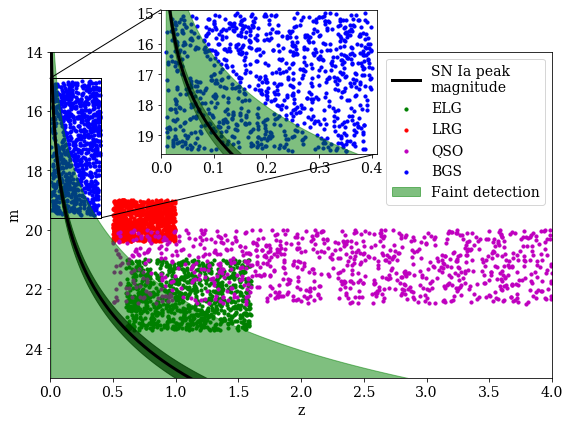

In [40]:
above_BGS = meta['BGS'][meta['BGS']['TEMPLATEID'] == 4787]

s=10
fig, ax = plt.subplots(1,1, figsize=(9,6))
for expid in range(1, 5):
    objtype = objtypes[expid-1]
    c = 'grmb'[expid-1]
    ax.scatter(meta[objtype]['REDSHIFT'], meta[objtype]['MAG'], 
               color=c, s=s, label='%s' % objtype)

# ax.scatter(above_BGS['REDSHIFT'], above_BGS['MAG'], 
#            color='k', label='Above example')

ax.plot(zrange, snia_peakmag, color='k', ls='-', 
        lw=3, label='SN Ia peak\nmagnitude')
ax.fill_between(zrange, snia_peakmag_lower, y2=snia_peakmag_upper, 
                color='k', alpha=0.75)
ax.fill_between(zrange, 30, y2=snia_faintdetection, 
                color='g', alpha=0.5, label='Faint detection')

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
# axins = inset_axes(ax, 2.5,2, loc=1, bbox_to_anchor=[2,2])
axins = inset_axes(ax, 3,2, loc=10, bbox_to_anchor=[300,350,0,0])
axins.scatter(meta['BGS']['REDSHIFT'], meta['BGS']['MAG'], color='b',
             s=s)
axins.plot(zrange, snia_peakmag, color='k', ls='-', 
        lw=3, label='SN Ia peak\nmagnitude')
axins.fill_between(zrange, snia_peakmag_lower, y2=snia_peakmag_upper, 
                color='k', alpha=0.5)
axins.fill_between(zrange, 30, y2=snia_faintdetection, 
                color='g', alpha=0.5)
x1, x2 = [0, 0.41]
y1, y2 = [19.6, 14.9]
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
# mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="k")
from matplotlib.patches import ConnectionPatch
xy1 = [x2, y1]
xy2 = [x1, y2]
con1 = ConnectionPatch(xyA=xy1, xyB=xy1, coordsA="data", coordsB="data",
                      axesA=ax, axesB=axins, color="k")
con2 = ConnectionPatch(xyA=xy2, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax, axesB=axins, color="k")
ax.add_artist(con1)
ax.add_artist(con2)
ax.plot([x1,x1],[y1,y2], color='k', lw=1)
ax.plot([x2,x2],[y1,y2], color='k', lw=1)
ax.plot([x1,x2],[y1,y1], color='k', lw=1)
ax.plot([x1,x2],[y2,y2], color='k', lw=1)

ax.set_xlabel('z', size=14)
ax.set_ylabel('m', size=14)
ax.set(xlim=[0, 4], ylim=[25, 14])
ax.tick_params(labelsize=14)
# plt.gca().invert_yaxis()
ax.legend(loc='upper right', fontsize=14)
savedir = '/Users/ryanrubenzahl/Library/Ryan/College/Senior Thesis/'
savedir += 'thesis/Figures/'
# plt.savefig(savedir + 'm_vs_z_galaxies_snia.pdf',
#             format='pdf', dpi=300, bbox_inches='tight')

# plt.savefig(savedir + 'm_vs_z_galaxies_snia_detectability.pdf',
#             format='pdf', dpi=300, bbox_inches='tight')